# Layerwise performance figure

Used for Wellcome grant.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = "Helvetica"
matplotlib.rcParams['font.size'] = 8.18
matplotlib.rcParams['figure.facecolor'] = 'white'


## Data import

In [5]:
model = 'ResNet6'
dataset = 'gmf_112x112_emo'
epoch = '050'

path = f'../results/{model}_dataset-{dataset}_target-id_epoch-{epoch}_perf.tsv'
df = pd.read_csv(path, sep='\t')
df = df.query("operation != 'softmax'")  # not interesting, discard
df = df.query("layername != 'layer00_input'")  # not really interesting, discard to save space

# Average performance across direction (X, Y, Z) for rotation, translation, and lights (X, Y)
df_rot = df.query("factor in ['xr', 'yr', 'zr']").groupby(['feature_nr', 'layername', 'layer', 'operation', 'op_nr']).mean(numeric_only=True).reset_index().assign(factor='rot')
df_trans = df.query("factor in ['xt', 'yt', 'zt']").groupby(['feature_nr', 'layername', 'layer', 'operation', 'op_nr']).mean(numeric_only=True).reset_index().assign(factor='trans')
df_light = df.query("factor in ['xl', 'yl']").groupby(['feature_nr', 'layername', 'layer', 'operation', 'op_nr']).mean(numeric_only=True).reset_index().assign(factor='lights')

# Instead of showing decodability of *all* shape and tex features, we show the decodability of the *best* shape and tex feature
# (not ideal, as this will be biased upwards, especially when the number of test identities is small --> high variance estimates)
df_tex = df.query("factor == 'tex'").groupby(['layername', 'layer', 'operation', 'op_nr']).max(numeric_only=True).reset_index().assign(factor='tex')
df_shape = df.query("factor == 'shape'").groupby(['layername', 'layer', 'operation', 'op_nr']).max(numeric_only=True).reset_index().assign(factor='shape')

# Concatenate all into a new dataframe
df = pd.concat([
    df_rot,
    df_trans,
    df_light,
    df_tex,
    df_shape,
    df.query("factor not in ['xr', 'yr', 'zr', 'xt', 'yt', 'zt', 'xl', 'yl', 'tex', 'shape']")
])

# Some nicer feature names
df = df.replace({'bg': 'backgr.', 'rot': 'rot.', 'trans': 'trans.', 'lights': 'lighting', 'tex': 'tex.', 'shape': 'shape', 'id': 'ID', 'gend': 'gender', 'ethn': 'ethn.', 'emo': 'emotion'})


Actual figure:

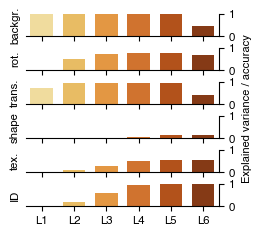

In [6]:
n_layers = df['layername'].nunique()
layernames = [f'L{i+1}' for i in range(n_layers)]
factors = ['backgr.', 'rot.', 'trans.', 'shape', 'tex.', 'ID']
n_factors = len(factors)
cmap = sns.color_palette("YlOrBr", n_colors=len(layernames) + 1)[1:]

fig, axes = plt.subplots(nrows=n_factors, figsize=(2.5, 2.5), sharex=True, sharey=True)

for i, factor in enumerate(factors):
    sns.barplot(x='layername', y='corr', ax=axes[i], data=df.query("factor == @factor"), palette=cmap, width=0.7)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(factor)
    axes[i].yaxis.tick_right()
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].legend([], frameon=False)
    axes[i].set_yticks([0, 1])
    axes[i].set_yticklabels(['0', '1'])

axes[-1].set_ylim(0, 1.)
axes[-1].set_xticklabels(layernames)
fig.text(1.01, 0.5, 'Explained variance / accuracy', va='center', ha='center', fontsize=8, rotation=90)
fig.subplots_adjust(hspace=0.5)
fig.savefig('./figures/layerwise_performance.pdf', bbox_inches='tight')